In [1]:
%matplotlib inline

!pip install pandas
!pip install matplotlib
!pip install seaborn

import pandas as pd

# Recomendation System for groups

## Dataset

### Loading the dataset

Mounting your google drive account

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
! cd "gdrive/My Drive/datasets/movieLensSmall" && ls -la 

total 3227
-rw------- 1 root root  197979 Oct  7  2018 links.csv
-rw------- 1 root root  494431 Oct  7  2018 movies.csv
-rw------- 1 root root 2483723 Oct  7  2018 ratings.csv
-rw------- 1 root root    8342 Oct  7  2018 README.txt
-rw------- 1 root root  118660 Oct  7  2018 tags.csv


In [4]:
!fold -w 80 -s "gdrive/My Drive/datasets/movieLensSmall/README.txt"

Summary

This dataset (ml-latest-small) describes 5-star rating and free-text tagging 
activity from [MovieLens](http://movielens.org), a movie recommendation 
service. It contains 100836 ratings and 3683 tag applications across 9742 
movies. These data were created by 610 users between March 29, 1996 and 
September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at 
least 20 movies. No demographic information is included. Each user is 
represented by an id, and no other information is provided.

The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` 
and `tags.csv`. More details about the contents and use of all these files 
follows.

This is a *development* dataset. As such, it may change over time and is not an 
appropriate dataset for shared research results. See available *benchmark* 
datasets if that is your intent.

This and other GroupLens data sets are publicly availabl

In [5]:
!wc -l "gdrive/My Drive/datasets/movieLensSmall/links.csv"
!wc -l "gdrive/My Drive/datasets/movieLensSmall/movies.csv"
!wc -l "gdrive/My Drive/datasets/movieLensSmall/ratings.csv"
!wc -l "gdrive/My Drive/datasets/movieLensSmall/tags.csv"

9743 gdrive/My Drive/datasets/movieLensSmall/links.csv
9743 gdrive/My Drive/datasets/movieLensSmall/movies.csv
100837 gdrive/My Drive/datasets/movieLensSmall/ratings.csv
3684 gdrive/My Drive/datasets/movieLensSmall/tags.csv


In [6]:
!head -n5 "gdrive/My Drive/datasets/movieLensSmall/links.csv"

movieId,imdbId,tmdbId
1,0114709,862
2,0113497,8844
3,0113228,15602
4,0114885,31357


In [7]:
!head -n5 "gdrive/My Drive/datasets/movieLensSmall/movies.csv"

movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance


In [8]:
!head -n5 "gdrive/My Drive/datasets/movieLensSmall/ratings.csv"

userId,movieId,rating,timestamp
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815


In [9]:
!head -n5 "gdrive/My Drive/datasets/movieLensSmall/tags.csv"

userId,movieId,tag,timestamp
2,60756,funny,1445714994
2,60756,Highly quotable,1445714996
2,60756,will ferrell,1445714992
2,89774,Boxing story,1445715207


### Dataset exploration

Loading dependencies

In [0]:
filepath_links = 'gdrive/My Drive/datasets/movieLensSmall/links.csv'
filepath_movies = 'gdrive/My Drive/datasets/movieLensSmall/movies.csv'
filepath_ratings = 'gdrive/My Drive/datasets/movieLensSmall/ratings.csv'
filepath_tags = 'gdrive/My Drive/datasets/movieLensSmall/tags.csv'

In [11]:
df_links = pd.read_csv(filepath_links)
df_links.head(10)
df_links.describe()

,movieId,imdbId,tmdbId
count,9742.000000,9.742000e+03,9734.000000
mean,42200.353623,6.771839e+05,55162.123793
std,52160.494854,1.107228e+06,93653.481487
min,1.000000,4.170000e+02,2.000000
25%,3248.250000,9.518075e+04,9665.500000
50%,7300.000000,1.672605e+05,16529.000000
75%,76232.000000,8.055685e+05,44205.750000
max,193609.000000,8.391976e+06,525662.000000


In [12]:
df_movies =  pd.read_csv(filepath_movies)
df_movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


Se puede observar que la columna que contien el título de la película, también contiene el año en el que esta ha sido lanzada, así que mejor vamos a separar esta información en dos columnas separadas

In [13]:
df_movies['has_year'] = df_movies['title'].apply(lambda x: "(" in x)
df_movies['has_year'].value_counts()

True     9730
False      12
Name: has_year, dtype: int64

Parece que hay películas que no contienen la fecha en el título

In [14]:
df_movies[df_movies['has_year'] == False]

,movieId,title,genres,has_year
6059,40697,Babylon 5,Sci-Fi,False
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,False
9091,143410,Hyena Road,(no genres listed),False
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),False
9179,149334,Nocturnal Animals,Drama|Thriller,False
9259,156605,Paterson,(no genres listed),False
9367,162414,Moonlight,Drama,False
9448,167570,The OA,(no genres listed),False
9514,171495,Cosmos,(no genres listed),False
9515,171631,Maria Bamford: Old Baby,(no genres listed),False


Parece que la columna de géneros siempre tiene los generos ordenados por categoría para cada entrada, así que vamos ver que agrupación son las más frecuentes

In [15]:
df_movies['genres'].value_counts()

Drama                                             1053
Comedy                                             946
Comedy|Drama                                       435
Comedy|Romance                                     363
Drama|Romance                                      349
Documentary                                        339
Comedy|Drama|Romance                               276
Drama|Thriller                                     168
Horror                                             167
Horror|Thriller                                    135
Crime|Drama                                        134
Crime|Drama|Thriller                               125
Drama|War                                          114
Comedy|Crime                                       101
Action|Comedy                                       92
Thriller                                            84
Children|Comedy                                     74
Comedy|Horror                                       69
Action|Adv

si probamos a representalo

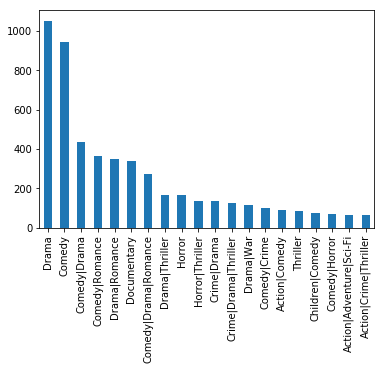

In [16]:
df_movies['genres'].value_counts()[:20].plot(kind='bar')

In [17]:
df_movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [18]:
df_ratings = pd.read_csv(filepath_ratings)
df_ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [19]:
df_movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [20]:
df_tags = pd.read_csv(filepath_tags)
df_tags.head(10)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
5,2,89774,Tom Hardy,1445715205
6,2,106782,drugs,1445715054
7,2,106782,Leonardo DiCaprio,1445715051
8,2,106782,Martin Scorsese,1445715056
9,7,48516,way too long,1169687325


In [21]:
df_tags.describe()

,userId,movieId,timestamp
count,3683.000000,3683.000000,3.683000e+03
mean,431.149335,27252.013576,1.320032e+09
std,158.472553,43490.558803,1.721025e+08
min,2.000000,1.000000,1.137179e+09
25%,424.000000,1262.500000,1.137521e+09
50%,474.000000,4454.000000,1.269833e+09
75%,477.000000,39263.000000,1.498457e+09
max,610.000000,193565.000000,1.537099e+09


### Data wrangling

Extraemos el año del título de la película para dispones de el como un campo separado para el análisis

In [22]:
df_movies['year'] = df_movies.title.str.extract("\((\d{4})\)", expand=True)
df_movies.year = pd.to_datetime(df_movies.year, format='%Y')
df_movies.year = df_movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
df_movies.title = df_movies.title.str[:-7]

df_movies.head()

,movieId,title,genres,has_year,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,True,1995.0
1,2,Jumanji,Adventure|Children|Fantasy,True,1995.0
2,3,Grumpier Old Men,Comedy|Romance,True,1995.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,True,1995.0
4,5,Father of the Bride Part II,Comedy,True,1995.0


Transforma los generos asociados a cada categoría como un One Hot Encoding

In [23]:
# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(df_movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
df_movies = df_movies.join(df_movies.genres.str.get_dummies().astype(bool))
df_movies.drop('genres', inplace=True, axis=1)
df_movies.head()

,movieId,title,has_year,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,True,1995.0,False,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji,True,1995.0,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men,True,1995.0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale,True,1995.0,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride Part II,True,1995.0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Otra transformación que vamos a realizar con el fin de comprender mejor el dataset es transformar el timestamp de las calificaciones realizadas por los usuarios a un formato más manejable

In [24]:
# Modify rating timestamp format (from seconds to datetime year)
#ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
df_ratings.timestamp = pd.to_datetime(df_ratings.timestamp, infer_datetime_format=True)
df_ratings.timestamp = df_ratings.timestamp.dt.year
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1970
1,1,3,4.0,1970
2,1,6,4.0,1970
3,1,47,5.0,1970
4,1,50,5.0,1970


Finalmente comprobamos los registros de cada dataframe que pueda contener valores nulos y al tratarse de unos pocos, simplemente prescendiremos de ellos

In [25]:
# Check and clean NaN values
print ("Number of movies Null values: ", max(df_movies.isnull().sum()))
print ("Number of ratings Null values: ", max(df_ratings.isnull().sum()))
df_movies.dropna(inplace=True)
df_ratings.dropna(inplace=True)

Number of movies Null values:  13
Number of ratings Null values:  0


Obtenemos todas las valoraciones realizadas para cada película

In [26]:
df_movie_rates = df_movies.set_index('movieId').join(df_ratings.set_index('movieId'))
df_movie_rates.head()

,title,has_year,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,userId,rating,timestamp
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story,True,1995.0,False,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,1.0,4.0,1970.0
1,Toy Story,True,1995.0,False,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,5.0,4.0,1970.0
1,Toy Story,True,1995.0,False,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,7.0,4.5,1970.0
1,Toy Story,True,1995.0,False,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,15.0,2.5,1970.0
1,Toy Story,True,1995.0,False,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,17.0,4.5,1970.0


In [27]:
avg_rate = df_movie_rates[['title','rating']].groupby('title').mean().sort_values(by='rating', ascending=False)
avg_rate

,rating
title,
Formula of Love,5.0
Down Argentine Way,5.0
Mother (Madeo),5.0
Light Years (Gandahar),5.0
Tokyo Tribe,5.0
Hunting Elephants,5.0
Big Top Scooby-Doo!,5.0
Into the Forest of Fireflies' Light,5.0
Goodbye Charlie,5.0


In [28]:
number_of_rates = df_movie_rates[['title','rating']].groupby('title').size().sort_values(ascending=False).rename('count').to_frame()
number_of_rates

,count
title,
Forrest Gump,329
"Shawshank Redemption, The",317
Pulp Fiction,307
"Silence of the Lambs, The",279
"Matrix, The",278
Star Wars: Episode IV - A New Hope,251
Jurassic Park,238
Braveheart,237
Terminator 2: Judgment Day,224


In [29]:
avg_rate.join(number_of_rates)

,rating,count
title,,
Formula of Love,5.0,1
Down Argentine Way,5.0,1
Mother (Madeo),5.0,1
Light Years (Gandahar),5.0,1
Tokyo Tribe,5.0,1
Hunting Elephants,5.0,1
Big Top Scooby-Doo!,5.0,1
Into the Forest of Fireflies' Light,5.0,1
Goodbye Charlie,5.0,1


Obtenemos todas las valoraciones realizada por cada usuario

In [30]:
df_each_user_ratings = df_ratings \
  .pivot(index="userId", columns="movieId", values="rating") \
  .fillna(0)

df_each_user_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data visualization

Como se distribuyen las valoraciones de los usuarios entre las películas

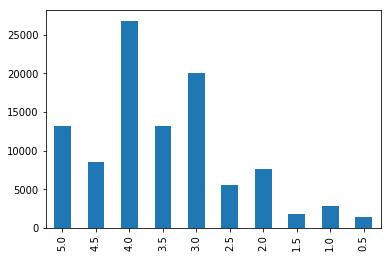

In [31]:
df_movie_rates[['title','rating']] \
  .rating.value_counts() \
  .sort_index(ascending=False) \
  .plot(kind='bar')


Número de valoraciones por los usuarios

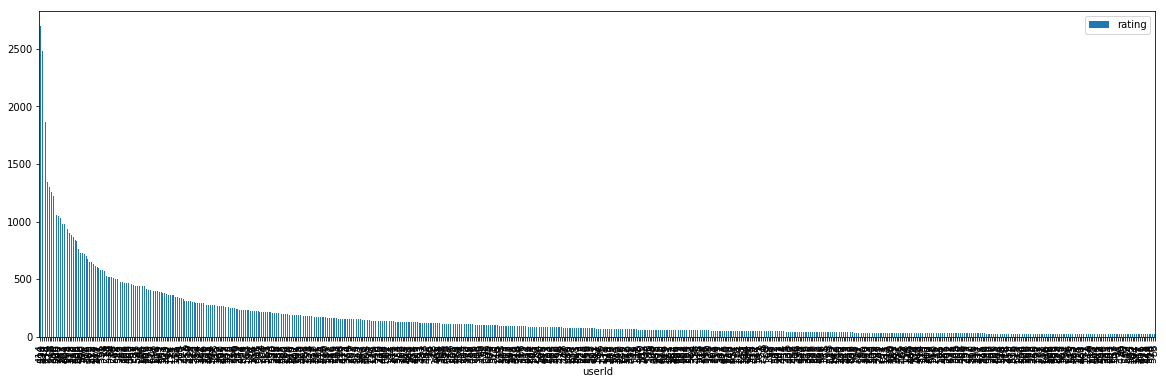

In [32]:
df_ratings[['userId','rating']] \
  .groupby('userId') \
  .count() \
  .sort_values(by='rating',ascending=False) \
  .plot(kind='bar',figsize=(20,6))

Hacemos zoom para mostrar el número de valoraciones de los 100 usuarios que más valoraciones han realizado

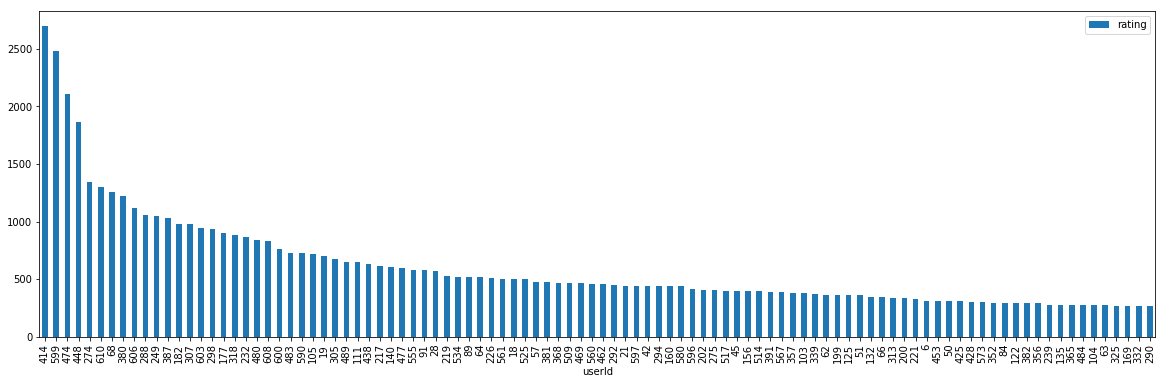

In [33]:
df_ratings[['userId','rating']] \
  .groupby('userId') \
  .count() \
  .sort_values(by='rating',ascending=False)[0:100] \
  .plot(kind='bar',figsize=(20,6))

Ahora hacemos zoom, para ver los 100 usuarios del dataset que menos valoraciones han realizado

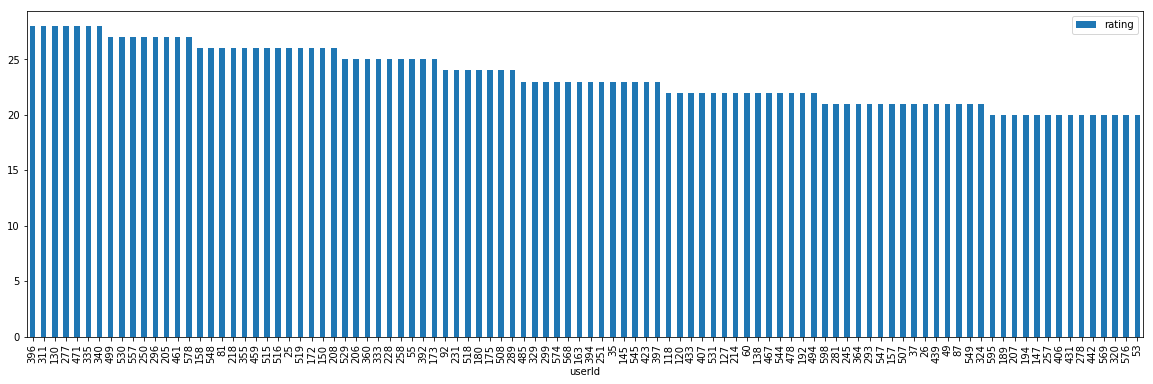

In [34]:
df_ratings[['userId','rating']] \
  .groupby('userId') \
  .count() \
  .sort_values(by='rating',ascending=False)[-100:] \
  .plot(kind='bar',figsize=(20,6))

Esta última gráfica resulta interesante, porque se puede ver que el dataset ha sido preparado de forma que todos los usuarios que realizasen menos de 20 valoraciones han sido excluidos, por lo tanto podemos asumir que partimos de un mínimo de información sobre los gustos de cada usuario del dataset

# Factorización de Matrices

Aqui procedere a explica la tećnica utilizada para la generación de recomendaciones individuales y a usarla

## Singular Value Decomposition

*Singular Value Decomposition* o *SVD*, es una técnia que factorización de matrices que proclamaa que dara una matriz **A**, esta puede descomponerse de la siguiente forma:

$A_{m \times n} \approx U_{m \times r} \Sigma_{r \times r} V_{n \times r}^{T}$

Donde:

- $A$: es la matriz con los datos de entrada a factorizar
  - matriz $m$ x $n$ ($m$ documentos, $n$ terminos)
- $U$: es la matriz izquierda de vectores de valores singulares
  -  matriz $m$ x $r$ ($m$ documentos, $r$ conceptos/ratings)
- $\Sigma$: valores singulares
  -  matriz diagonal $r$ x $r$ (representa el peso de cada concepto)
  - $r$; rango de la matriz $A$
- $V$: es la matriz derecha de vectores de valores singulares
  - matriz $n$ x $r$ ($n$ terminos, $r$ conceptos/ratings)
  
En la *figura 1* podemos ver un ejemplo de la representación de las matrices aplicado a *NLP* (Natural Language Processing), en el que las columnas de la matriz $A$ representan frases y las filas representan (mediante un índice) la pertenencia de una palabra a las diferentes frases.
  
![figura1: imagen ilustrando las matrices](https://www.researchgate.net/profile/Sadaoki_Furui/publication/228735398/figure/fig1/AS:393708286562313@1470878778585/Application-of-Singular-Value-Decomposition-SVD-to-each-presentation.png)

*figura1: imagen ilustrando las matrices*





## Propiedades

SVD establece que **siempre** es posible descomponen la matriz $A$ en $A \approx U \Sigma V$, de tal forma que:

- $U, \Sigma, V$: son únicas
- $U, V$: tienen columnas ortonormales
  - $U^{T} U = I, V^{T} V = I$
  - Las columnas son vectores unitarios ortogonales
- $\Sigma$: diagonal
  - Las entradas (valores singulares) son positivas y se encuentran ordenadas decrecientemente ($\sigma_1 \geq \sigma_2 \geq ... \geq  0  $)
  

## Como realizar la factorización

Una vez explicado en que consiste *SVD*, el siguiente paso es plantearse como realizar el proceso  de decomposición de la matriz A. Esto se puede plantear como un proceso de optimización en el que vamos generando matrices $U$ y $V$ a la vez que observamos como la matriz resultante $\hat{A}$ difiere de la matriz original $A$, donde para ello podemos utilizar una métrica de error como el RMSE.

$error(A,U,V) = RMSE(A.\hat{A})= RMSE(A.UV)$

$RMSE(A.UV)) = \sqrt{\sum_{u,i} (\hat{r}_{ui} - r_{ui})^2}$ donde $\hat{r} \in UV$ y $r \in A$

Se puede ver que se está obviando la matriz diagonal $\Sigma$ en este proceso, esto se debe a que en la práctica, podemos considerar que esta matriz ya se encuentra integrada en las matrices $U$ y $V$, simplicando así las operaciones necesarias para el proceso de obtención de dichas matrices.

Ahora que tenemos una métrica de error y planteado el problema, podemos aplicar un mecanismo de optimización como SGD (Stochastic Gradiand Descend) e ir iterando de forma que, en cada iteración, generemos un nuevo par de matrices $U$ y $V$ guiadas por el descenso del gradiente, que traten de minimizar el error cometido al generar la matriz $\hat{A}$



### Implementación simple

In [35]:
import numpy as np

np.random.seed(1337)

A = np.random.rand(10, 10)
A = A * A

# prettify print options for matrix
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print(A)

# set print options back to normal
np.set_printoptions(edgeitems=3,infstr='inf', linewidth=75, nanstr='nan', precision=8, suppress=False, threshold=1000, formatter=None)


[[ 0.069  0.025  0.077  0.211  0.103  0.269  0.069  0.953  0.537  0.013]
 [ 0.149  0.395  0.016  0.967  0.196  0.623  0.631  0.131  0.173  0.341]
 [ 0.578  0.035  0.083  0.449  0.250  0.032  0.171  0.040  0.283  0.693]
 [ 0.034  0.917  0.181  0.254  0.261  0.000  0.535  0.987  0.027  0.016]
 [ 0.141  0.481  0.000  0.136  0.003  0.623  0.122  0.494  0.241  0.946]
 [ 0.699  0.372  0.319  0.995  0.065  0.000  0.008  0.882  0.948  0.242]
 [ 0.116  0.523  0.000  0.578  0.451  0.036  0.444  0.830  0.026  0.829]
 [ 0.105  0.490  0.070  0.269  0.031  0.219  0.202  0.157  0.627  0.243]
 [ 0.524  0.629  0.124  0.827  0.508  0.805  0.177  0.219  0.817  0.401]
 [ 0.284  0.056  0.896  0.313  0.574  0.056  0.185  0.155  0.261  0.016]]


In [0]:
def simple_SGD(data,n_factors = 10, alpha = .01, n_epochs = 10):
  '''Learn the vectors p_u and q_i with SGD.
     data is the user-item matrix
     n_factor is the number of latent factors to use
     alppha is the learning rate of the SGD
     n_epochs is the number of iterations to run the algorithm
  '''
  shape = np.shape(data)
  n_users = shape[0]
  n_items = shape[1]

  # Randomly initialize the user and item factors.
  p = np.random.normal(0, .1, (n_users, n_factors))
  q = np.random.normal(0, .1, (n_items, n_factors))

  # Optimization procedure
  for _ in range(n_epochs):
      for (u, i), r_ui in np.ndenumerate(data):
          err = r_ui - np.dot(p[u], q[i])
          # Update vectors p_u and q_i
          p[u] += alpha * err * q[i]
          q[i] += alpha * err * p[u]

  return p,q
            
def rmse(U,V):
  errors = U - V
  return np.sqrt(np.sum(errors*errors) / errors.size)
  
  
  
n_factors = 5 # number o latent factors
alpha = .01 # learning rate
n_epochs = 5000 # number of iteration of the SGD procedure

u,v = simple_SGD(A,n_factors,alpha,n_epochs)

RMSE: 0.10888291026731306


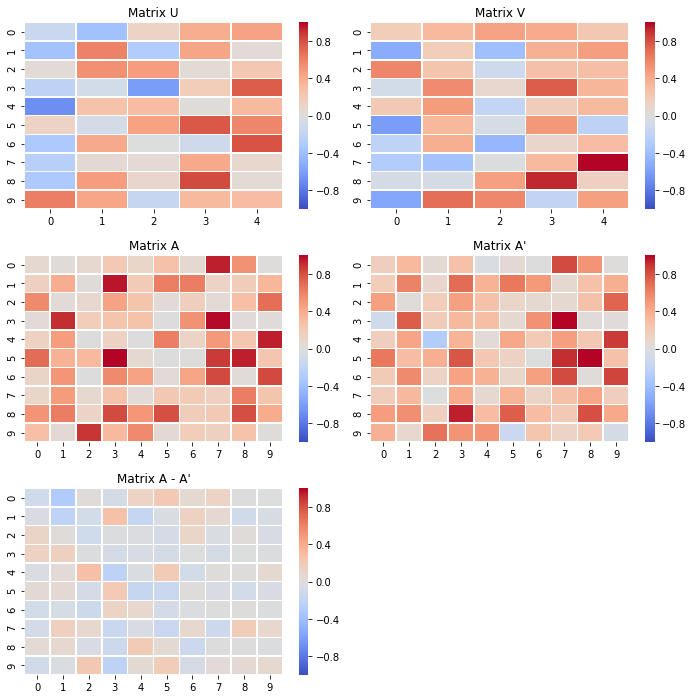

In [37]:
import seaborn as sns
import matplotlib.pylab as plt

print("RMSE: {}".format(rmse(A,u.dot(v.T))))

plt.subplots(figsize=(12,12))
plt.subplot(321)
ax = sns.heatmap(u, linewidth=0.5, vmin=-1, vmax=1, cmap="coolwarm").set_title("Matrix U")
plt.subplot(322)
ax = sns.heatmap(v, linewidth=0.5, vmin=-1, vmax=1, cmap="coolwarm").set_title("Matrix V")
plt.subplot(323)
ax = sns.heatmap(A, linewidth=0.5, vmin=-1, vmax=1, cmap="coolwarm").set_title("Matrix A")
plt.subplot(324)
ax = sns.heatmap(u.dot(v.T), linewidth=0.5, vmin=-1, vmax=1, cmap="coolwarm").set_title("Matrix A'")
plt.subplot(325)
ax = sns.heatmap(A - u.dot(v.T), linewidth=0.5, vmin=-1, vmax=1, cmap="coolwarm").set_title("Matrix A - A'")

plt.subplots_adjust(hspace=0.25, wspace=0.07)
plt.show()

## Adaptación para matrices dispersas

El algoritmo propuesto cumple con su cometido en el caso de que le proporcionemos una matriz a factorizar que no sea dispersa, pero el problema  nos los encontramos cuando tratamos de aplicar dicho método sobre una matriz dispersa, ya que para valoraciones de las que no disponemos en la matriz, no podemos calcular el error que cometemos.

La solución a esta casuística resulta bastante sencilla, simplemente calculamos las matrices $U$ y $V$ teniendo en cuenta únicamente las valoraciones que tenemos para calcular el gradiente y los factores latentes que componen las matrices $U$ y $V$. Si tenemos suficientes valoraciones, los factores latentes se ajustarán de tal forma que representen los gustos de los usuarios y las películas, lo que dará lugar a que sea capaz de generar recomendaciones adecuadas. 

### Implementación

In [38]:
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt

np.random.seed(1337)

A = np.random.rand(10, 10)
A = A * A

A[0,1:5] = 0
A[1,5:9] = 0

# prettify print options for matrix
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print(A)

# set print options back to normal
np.set_printoptions(edgeitems=3,infstr='inf', linewidth=75, nanstr='nan', precision=8, suppress=False, threshold=1000, formatter=None)


[[ 0.069  0.000  0.000  0.000  0.000  0.269  0.069  0.953  0.537  0.013]
 [ 0.149  0.395  0.016  0.967  0.196  0.000  0.000  0.000  0.000  0.341]
 [ 0.578  0.035  0.083  0.449  0.250  0.032  0.171  0.040  0.283  0.693]
 [ 0.034  0.917  0.181  0.254  0.261  0.000  0.535  0.987  0.027  0.016]
 [ 0.141  0.481  0.000  0.136  0.003  0.623  0.122  0.494  0.241  0.946]
 [ 0.699  0.372  0.319  0.995  0.065  0.000  0.008  0.882  0.948  0.242]
 [ 0.116  0.523  0.000  0.578  0.451  0.036  0.444  0.830  0.026  0.829]
 [ 0.105  0.490  0.070  0.269  0.031  0.219  0.202  0.157  0.627  0.243]
 [ 0.524  0.629  0.124  0.827  0.508  0.805  0.177  0.219  0.817  0.401]
 [ 0.284  0.056  0.896  0.313  0.574  0.056  0.185  0.155  0.261  0.016]]


In [39]:
def simple_SGD2(data,n_factors = 10, alpha = .01, n_epochs = 10):
  '''Learn the vectors p_u and q_i with SGD.
     data is the user-item matrix
     n_factor is the number of latent factors to use
     alppha is the learning rate of the SGD
     n_epochs is the number of iterations to run the algorithm
  '''
  print(type(data))
  
  shape = np.shape(data)
  n_users = shape[0]
  n_items = shape[1]

  # Randomly initialize the user and item factors.
  p = np.random.normal(0, .1, (n_users, n_factors))
  q = np.random.normal(0, .1, (n_items, n_factors))

  # Optimization procedure
  for _ in range(n_epochs):
      for (u, i), r_ui in np.ndenumerate(data):
          if(r_ui > 0):
            err = r_ui - np.dot(p[u], q[i])
            # Update vectors p_u and q_i
            p[u] += alpha * err * q[i]
            q[i] += alpha * err * p[u]

  return p,q
            
def rmse(U,V):
  errors = U - V
  return np.sqrt(np.sum(errors*errors) / errors.size)
  
  
  
n_factors = 5 # number o latent factors
alpha = .01 # learning rate
n_epochs = 5000 # number of iteration of the SGD procedure

u,v = simple_SGD2(A,n_factors,alpha,n_epochs)

<class 'numpy.ndarray'>


RMSE: 0.27191355220596636


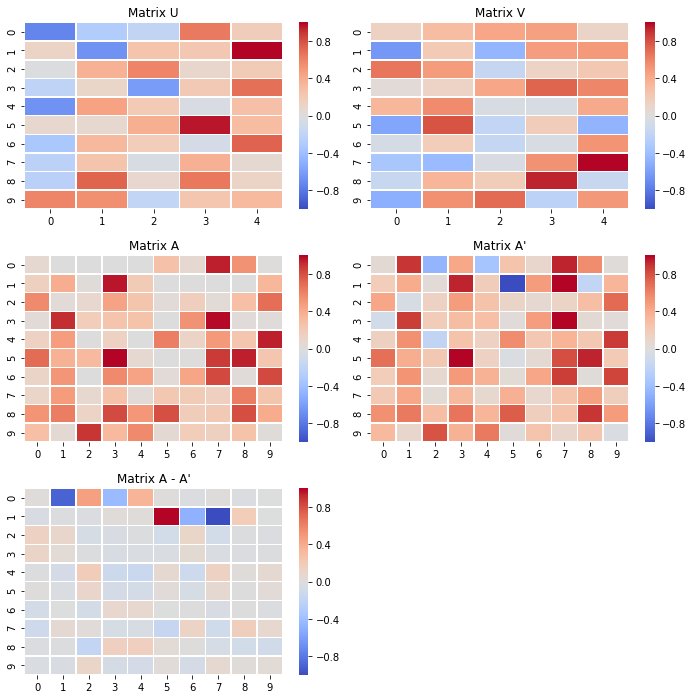

In [40]:
import seaborn as sns
import matplotlib.pylab as plt

print("RMSE: {}".format(rmse(A,u.dot(v.T))))

plt.subplots(figsize=(12,12))
plt.subplot(321)
ax = sns.heatmap(u, linewidth=0.5, vmin=-1, vmax=1, cmap="coolwarm").set_title("Matrix U")
plt.subplot(322)
ax = sns.heatmap(v, linewidth=0.5, vmin=-1, vmax=1, cmap="coolwarm").set_title("Matrix V")
plt.subplot(323)
ax = sns.heatmap(A, linewidth=0.5, vmin=-1, vmax=1, cmap="coolwarm").set_title("Matrix A")
plt.subplot(324)
ax = sns.heatmap(u.dot(v.T), linewidth=0.5, vmin=-1, vmax=1, cmap="coolwarm").set_title("Matrix A'")
plt.subplot(325)
ax = sns.heatmap(A - u.dot(v.T), linewidth=0.5, vmin=-1, vmax=1, cmap="coolwarm").set_title("Matrix A - A'")

plt.subplots_adjust(hspace=0.25, wspace=0.07)
plt.show()

In [41]:
# prettify print options for matrix
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print("Matriz original de valoraciones")
print(A)
print("\nMatriz aprendida mediante la factorización")
print(u.dot(v.T))
# set print options back to normal
np.set_printoptions(edgeitems=3,infstr='inf', linewidth=75, nanstr='nan', precision=8, suppress=False, threshold=1000, formatter=None)


Matriz original de valoraciones
[[ 0.069  0.000  0.000  0.000  0.000  0.269  0.069  0.953  0.537  0.013]
 [ 0.149  0.395  0.016  0.967  0.196  0.000  0.000  0.000  0.000  0.341]
 [ 0.578  0.035  0.083  0.449  0.250  0.032  0.171  0.040  0.283  0.693]
 [ 0.034  0.917  0.181  0.254  0.261  0.000  0.535  0.987  0.027  0.016]
 [ 0.141  0.481  0.000  0.136  0.003  0.623  0.122  0.494  0.241  0.946]
 [ 0.699  0.372  0.319  0.995  0.065  0.000  0.008  0.882  0.948  0.242]
 [ 0.116  0.523  0.000  0.578  0.451  0.036  0.444  0.830  0.026  0.829]
 [ 0.105  0.490  0.070  0.269  0.031  0.219  0.202  0.157  0.627  0.243]
 [ 0.524  0.629  0.124  0.827  0.508  0.805  0.177  0.219  0.817  0.401]
 [ 0.284  0.056  0.896  0.313  0.574  0.056  0.185  0.155  0.261  0.016]]

Matriz aprendida mediante la factorización
[[ 0.051  0.891 -0.467  0.427 -0.357  0.255  0.087  0.943  0.556  0.019]
 [ 0.181  0.405  0.034  0.942  0.173 -1.209  0.489  1.963 -0.186  0.347]
 [ 0.436 -0.051  0.138  0.488  0.263  0.110  0.

# Generación de predicciones

Lo primero es realizar la factorización de matrices sobre la matriz de valoraciones de usuarios aplicando SVD

In [42]:
n_factors = 50
alpha = 0.01
n_epochs = 100
u,v = simple_SGD2(df_each_user_ratings, n_factors, alpha, n_epochs)

<class 'pandas.core.frame.DataFrame'>


De cara a generar las recomendaciones para un usuario, llega con multiplica la fila correspondiente al usuario en la matriz que contiene los factores latentes de los usuarios($U[usuario,]$), por matriz traspuestas que contiene todos la factores latentes de las películas ($V^T$),

In [43]:
u[0].shape

(50,)

In [44]:
v.T.shape

(50, 9724)

In [45]:
u[0].dot(v.T)

array([4.21591503, 3.79842813, 4.12853265, ..., 1.64174382, 2.47908129,
       3.21313069])

Si queremos generar todas las recomendaciones, para todos los usuarios, llegaría con multiplicar la matriz $U$ con $V^T$. Que podemos ver que tiene las mismas dimensiones que la matriz de valoraciones original

In [46]:
u.dot(v.T).shape

(610, 9724)

In [47]:
df_each_user_ratings.shape

(610, 9724)

# Tecnicas de recomendación para grupos

Dado que el dataset no contiene grupos como tal y muchos menos existen valoraciones explicitas realizadas por un grupo de usuarios(que permitiría abordar el problema simplemente tratando los grupos como usuarios), para la generación de recomendaciones grupales, se ha preferido optar por la exploración de agregaciones de las recomendaciones individuales de los usuarios que conforman un grupo. Además este tipo de agregaciones se puede aplicar sobre cualquier grupo de usuarios, sin necesidad de tener información previa del propio grupo, es decir, siempre podemos generar recomendaciones ante una nueva combinación de usuarios que se acabe de formar.

Lo primero que necesitamos para explorar estas agregaciones, es formar un grupo de usuarios que solicitan que les recomienden películas

In [48]:
total_users = u.shape[0]
group_size = 5

users = np.random.randint(total_users, size=group_size)
users

array([383,  95, 366,  98, 477])

A continuación podemos ver los factores latentes de cada usuario que conforma el grupo aleatorio que se acaba de crear

In [49]:
group_latent_factors = u[users]
group_latent_factors

array([[ 1.12346363e+00,  1.23025842e-01,  2.48649284e-02,
        -5.78537232e-01,  4.70591683e-01,  1.25625866e+00,
         8.13316513e-01,  1.01539615e-01, -8.90614313e-02,
        -2.69570662e-01,  5.73283369e-01, -5.97172664e-02,
        -2.89190149e-01,  1.38697126e-01,  4.79102876e-01,
        -3.63304413e-01, -1.10059738e+00, -1.33656809e-01,
        -7.89061633e-01,  3.87304716e-01,  8.09312336e-03,
         1.80737735e-01, -3.11223671e-01, -2.91140426e-01,
         6.45881121e-01, -4.32242684e-01,  1.68279346e-01,
         6.90765220e-01, -2.16574216e-02, -1.94788958e-01,
        -1.21009076e-01,  1.02591955e+00,  3.83810220e-01,
        -6.48064231e-01,  1.22849215e-01, -7.36432750e-01,
        -6.07146870e-01,  6.69298463e-01, -3.49748528e-02,
        -3.06670989e-02,  1.41724746e-01, -1.87137870e-02,
         4.57159967e-01,  5.04796820e-01,  4.15830459e-02,
         2.10300472e-02, -3.70506348e-01,  1.49655546e+00,
        -3.06984690e-01,  1.21752005e-01],
       [ 7.39

Y estas serían las predicciones individuales para cada miembro del grupo

In [50]:
group_individual_recommendations = group_latent_factors.dot(v.T)
group_individual_recommendations

array([[5.10239423, 2.22071579, 2.79964582, ..., 1.77469039, 1.53806327,
        2.44905738],
       [4.39270945, 3.27591223, 2.65964213, ..., 2.26642673, 2.44483001,
        2.83610671],
       [4.97569951, 2.57248542, 3.1092161 , ..., 1.51902206, 2.44509515,
        4.37492714],
       [4.50735652, 5.67135937, 2.87275592, ..., 1.00665556, 1.77858396,
        2.81478851],
       [3.49117767, 2.72865084, 2.80715308, ..., 1.47871212, 1.46058451,
        2.75185813]])

Si ordenamos las predicciones por usuario, en base a los valores que se acaban de generar, podemos ver que cada usuario tiene diferentes preferencias. Ya que en la columna 0, que contiene la mejor película para cada usuario, todos presentan diferentes películas y lo mismo sucede para el resto de columnas

In [51]:
movies_id_for_each_user_order_by_likehood = np.argsort(-group_individual_recommendations)
movies_id_for_each_user_order_by_likehood

array([[2027, 1916, 1230, ..., 1077, 7744, 8875],
       [ 520, 3012,  618, ..., 7990, 8875, 8399],
       [ 485, 3563,  992, ..., 8875, 8913, 2034],
       [  43, 1066, 1795, ..., 7458, 9022, 8694],
       [1796, 3191, 7396, ..., 5649, 5200, 8875]])

Ahora que tenemos las recomendaciones individuales para cada uno de los elementos del grupo, procederemos a utilizar diferentes técnicas de agregación de las recomendaciones para la generación de las recomnedaciones finales para el grupo

## Media de las recomendaciones individuales
La primera agregación básica que podemos considerar de cara a generar las recomendaciones para el grupo, es el uso de la media de las valoraciones predichas de cada usuario para cada película y acto seguido recomendar las películas que presenten un valor más alto para la media.

In [52]:
mean_recommendations = np.mean(group_individual_recommendations, axis=0)
mean_recommendations_indexs = np.argsort(-mean_recommendations)
mean_recommendations_indexs 

array([ 602, 2077,  982, ..., 8399, 8694, 8875])

Recupero el título de las películas que forman parte de las mejores 30 recomendaciones

In [53]:
df_movies.loc[mean_recommendations_indexs].title[0:30]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


602     Dr. Strangelove or: How I Learned to Stop Worr...
2077                                      Iron Giant, The
982                                             High Noon
1066                                          Under Siege
520                                                 Fargo
277                             Shawshank Redemption, The
1043                                           Nightwatch
2592                                                  Hud
899                                   Princess Bride, The
27                                             Persuasion
898        Star Wars: Episode V - The Empire Strikes Back
2979                                       102 Dalmatians
224                    Star Wars: Episode IV - A New Hope
964                                         Groundhog Day
485                                             Tombstone
901                                                Brazil
510                             Silence of the Lambs, The
974           

El problema de esta mecanismo de agregación es que si un usuario tiene gustos muy diferentes comparados con el resto del grupo, sus preferencias quedaran ignoradas con respecto al resto del grupo, lo que poderíamos llegar a considerar como una mala recomendación según el escenario

## Multiplicación de las recomendaciones individuales
Otra medida de agregación similar a la media y con un comportamiento similar en este caso, que altera ligeramente las recomendaciones, es la agregación de las recomendaciones indivuduales de cada película mediante la multiplicación de la valoraciones individuales de cada usuario para cada película

In [54]:
multiply_recommendations = np.prod(group_individual_recommendations, axis=0)
multiply_recommendations_indexs = np.argsort(-multiply_recommendations)
multiply_recommendations_indexs 

array([ 982,  602, 2077, ..., 1144,  145, 2034])

Recupero el título de las películas que forman parte de las mejores 30 recomendaciones

In [55]:
df_movies.loc[multiply_recommendations_indexs].title[0:30]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


982                                             High Noon
602     Dr. Strangelove or: How I Learned to Stop Worr...
2077                                      Iron Giant, The
1066                                          Under Siege
277                             Shawshank Redemption, The
1043                                           Nightwatch
2592                                                  Hud
27                                             Persuasion
898        Star Wars: Episode V - The Empire Strikes Back
899                                   Princess Bride, The
520                                                 Fargo
224                    Star Wars: Episode IV - A New Hope
964                                         Groundhog Day
510                             Silence of the Lambs, The
974                                            Highlander
913                                        Third Man, The
46                                    Usual Suspects, The
1211          

Al igual que en el caso anterior, el problema de esta técnica de agregación vuelven a ser los usuarios que presentan gustos diferentes  a los principales del grupo. A continuación se muestran dos ejemplos de posibles agregaciones, para un grupo formado por 3 usuarios, y no queda claro si realmente sería mejor recomendar la primera película en vez de la segunda

In [83]:
1*5*5

25

In [86]:
2*3*4

24

## Borda Count
Este método de agregacón consiste en asignar puntos a las películas en función de en que posición aparecentro dentro del ranking individual de recomendaciones de cada usuario, recibiendo la primera película un número de puntos igual al número de peliculas en el ranking y recibiendo la última película del ranking 0 puntos. Finalmente se suman los puntos obtenidos por cada película y se ordenan las películas en base a estos


In [56]:
movies_id_for_each_user_order_by_likehood

array([[2027, 1916, 1230, ..., 1077, 7744, 8875],
       [ 520, 3012,  618, ..., 7990, 8875, 8399],
       [ 485, 3563,  992, ..., 8875, 8913, 2034],
       [  43, 1066, 1795, ..., 7458, 9022, 8694],
       [1796, 3191, 7396, ..., 5649, 5200, 8875]])

In [57]:
number_of_movies = df_movies.shape[0]
borda_rating = np.arange(1, number_of_movies+1)
borda_rating

array([   1,    2,    3, ..., 9727, 9728, 9729])

In [58]:
with np.nditer(borda_rating, op_flags=['readwrite']) as it:
  for x in it:
    positions_inside_individual_recommendations = np.where(movies_id_for_each_user_order_by_likehood == x)[1]
    value_by_position_inside_each_ranking = number_of_movies - positions_inside_individual_recommendations
    x[...] = value_by_position_inside_each_ranking.sum()
    
borda_rating

array([34111, 32883, 22427, ...,     0,     0,     0])

Recupero el título de las películas que forman parte de las mejores 30 recomendaciones

In [59]:
borda_recommendations_indexs = np.argsort(-borda_rating)
df_movies.loc[borda_recommendations_indexs].title[0:30]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


981                                           Fantasia
2076                                              Dick
1042                                Breaking the Waves
1210                             187 (One Eight Seven)
897                     Cheech and Chong's Up in Smoke
601                                       Arrival, The
276                                  Santa Clause, The
7126                       Men Who Stare at Goats, The
963                                               Diva
4130                                    Hot Chick, The
4754                      Hunchback of Notre Dame, The
795                                  Secret Agent, The
6630                                       I Am Legend
223                                      Kiss of Death
2591                                   Heart and Souls
106                                          Boomerang
996                               Pink Floyd: The Wall
3632     Spacehunter: Adventures in the Forbidden Zone
1420      

## Copeland Rule
Se calcula la valoración media de cada película y se ordenan estas en un raking, una vez ordenadas, se genera una nueva valoración para cada película en base al número de peliculas que se encuentran por debajo de cada película en el ranking, menos el número de películas que se encuentran por encima de cada película en el ranking



In [60]:
add_recommendations = np.mean(group_individual_recommendations, axis=0)
index_sorted_elements = np.argsort(-add_recommendations)
index_sorted_elements

array([ 602, 2077,  982, ..., 8399, 8694, 8875])

In [61]:
copeland_values = np.arange(0, index_sorted_elements.shape[0])
copeland_values

array([   0,    1,    2, ..., 9721, 9722, 9723])

In [62]:
with np.nditer(copeland_values, op_flags=['readwrite']) as it:
  for x in it:
    positive = np.where(index_sorted_elements == x)[0][0]
    x[...] = positive - (number_of_movies - positive)
    
copeland_values

array([-9679, -6307, -3091, ...,  5443,  3421, -4581])

Recupero el título de las películas que forman parte de las mejores 30 recomendaciones

In [63]:
copeland_recommendations_indexs = np.argsort(-copeland_values)
df_movies.loc[borda_recommendations_indexs].title[0:30]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


981                                           Fantasia
2076                                              Dick
1042                                Breaking the Waves
1210                             187 (One Eight Seven)
897                     Cheech and Chong's Up in Smoke
601                                       Arrival, The
276                                  Santa Clause, The
7126                       Men Who Stare at Goats, The
963                                               Diva
4130                                    Hot Chick, The
4754                      Hunchback of Notre Dame, The
795                                  Secret Agent, The
6630                                       I Am Legend
223                                      Kiss of Death
2591                                   Heart and Souls
106                                          Boomerang
996                               Pink Floyd: The Wall
3632     Spacehunter: Adventures in the Forbidden Zone
1420      

##Least Misery
Genera un raking de películas, tomando para cada película la peor valoración realizada por un miembro del grupo


In [64]:
least_misery_recommendations = np.amin(group_individual_recommendations, axis=0)
least_misery_indexs = np.argsort(-least_misery_recommendations)
least_misery_indexs 

array([ 898,  982, 1066, ..., 8875, 2034, 8399])

Recupero el título de las películas que forman parte de las mejores 30 recomendaciones

In [65]:
df_movies.loc[least_misery_indexs].title[0:30]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


898       Star Wars: Episode V - The Empire Strikes Back
982                                            High Noon
1066                                         Under Siege
4755                                         42nd Street
27                                            Persuasion
680                              Philadelphia Story, The
277                            Shawshank Redemption, The
74                              Antonia's Line (Antonia)
107               Chungking Express (Chung Hing sam lam)
974                                           Highlander
7127                                Hunt For Gollum, The
965                                           Unforgiven
9300                                        Kill Command
4931    Scenes From a Marriage (Scener ur ett äktenskap)
2077                                     Iron Giant, The
2590                                        Modern Times
913                                       Third Man, The
6810                   Heart of

## Most Pleasure
Genera un raking de películas, tomando para cada película la mejor valoración realizada por un miembro del grupo
ure


In [66]:
most_pleasure_recommendations = np.amax(group_individual_recommendations, axis=0)
most_pleasure_indexs = np.argsort(-most_pleasure_recommendations)
most_pleasure_indexs 

array([ 520,  485, 3563, ..., 4656, 7280, 8875])

Recupero el título de las películas que forman parte de las mejores 30 recomendaciones

In [67]:
df_movies.loc[most_pleasure_indexs].title[0:30]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


520                                          Fargo
485                                      Tombstone
3563                      High Heels and Low Lifes
3012                                  Dracula 2000
618                   Hunchback of Notre Dame, The
2978                   Rugrats in Paris: The Movie
906                             Lawrence of Arabia
992                                         Gandhi
15                                          Casino
311                                      Crow, The
1231                                   Chasing Amy
1544                            Lady and the Tramp
1294                          Horse Whisperer, The
2729            Puppet Master 5: The Final Chapter
2903                                   Nurse Betty
434                         Much Ado About Nothing
7987                                         V/H/S
6520                                 Evan Almighty
43                            Seven (a.k.a. Se7en)
5938                           

##Average without Misery

Consiste en calcular la media de las recomendaciones individuales predichas para cada usuario, ignorando todas aquellas valoraciones inferiores a un umbral que seleccionemos previamente


In [68]:
average_without_misery_values = np.arange(0, index_sorted_elements.shape[0])

threshold = 3
columns = group_individual_recommendations.T
idx = 0
for column in columns:
  valid = column > threshold
  filtered = column[valid]
  value = np.mean(filtered)
  if (np.isnan(value)):
    value = 0
  average_without_misery_values[idx] = value
  idx += 1 
  
average_without_misery_indexs = np.argsort(-average_without_misery_values)
average_without_misery_indexs 

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


array([6522, 1548, 2979, ..., 5850,  480, 5243])

Recupero el título de las películas que forman parte de las mejores 30 recomendaciones

In [69]:
df_movies.loc[average_without_misery_indexs].title[0:30]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


6522    Harry Potter and the Order of the Phoenix
1548                                      Newsies
2979                               102 Dalmatians
2034                           Muppets From Space
8532                                 Captive, The
2044                                  Mystery Men
1397              Buffalo '66 (a.k.a. Buffalo 66)
485                                     Tombstone
618                  Hunchback of Notre Dame, The
2823                  The Golden Voyage of Sinbad
3081                           Monster Squad, The
520                                         Fargo
4527                   Once Upon a Time in Mexico
8161                                       Darkon
2603                                    Ladyhawke
1230                               Ice Storm, The
992                                        Gandhi
7594                               Mildred Pierce
2476                                   Hanging Up
2341                                      Shampoo


## Agregación seleccionada

Tras probar las diferentes técnicas para agregar las recomendaciones individuales, resulta complicado decantarse por una en concreto sin disponer de mayor información del contexto en el que se está generando la recomendación. Ya que existen incógnitas de las que no disponemos ningún tipo de recomendación, como pueden ser:

- existen usuarios que puedan influenciar al resto del grupo en su valoración?
- existen usuarios que estean dispuestos a ignorar sus preferencias por el "bien" del grupo?
- que tipo de recomendación consideramos "mejores" para un grupo, en el caso de que sus usuarios presenten opiniones muy diferentes?

Ante incógnitdas como las planteadas, la técnica de agregación **Least Misery**, parece la mejor opción a la hora de mantener contentos a todos los usuarios del grupo con la generación recomendada, pero al tratarse de una técnica que se basa en la peores de las valoraciones individuales, será complicado generar recomendaciones que resulten sorprendentes al grupo de usuarios

# Recursos consultados

1. [Lecture 47 — Singular Value Decomposition | Stanford University](https://www.youtube.com/watch?v=P5mlg91as1c)
2. [Understanding matrix factorization for recommendation (part 4) - algorithm implementation](http://nicolas-hug.com/blog/matrix_facto_4)
3. Takács, G., Pilászy, I., Németh, B., & Tikk, D. (2014). Matrix factorization and neighbor based algorithms for the netflix prize problem Sugeno-Yasukawa qualitative modeling View project Matrix Factorization and Neighbor Based Algorithms for the Netflix Prize Problem General Terms. http://doi.org/10.1145/1454008.1454049
4. J. Masthoff. Group recommender systems: combining individual models. In F. Ricci, L. Rokach, B. Shapira, and P. B. Kantor, editors, Recommender Systems Handbook, page 677. Springer US, Boston, MA, 2011. 